In [ ]:
# Run this block to install dependencies [Remember to make the statement true]
if 0 != 1:
    !pip install pandas
    !pip install tqdm
    !pip install scikit-learn
    !pip install gensim
    !pip install spacy
    !python -m spacy download en
    !pip install numpy

In [1]:
import pandas as pd
import spacy
import pickle
from tqdm import tqdm
from gensim.corpora import Dictionary
from sklearn.utils import shuffle
from collections import defaultdict
import numpy as np

nlp = spacy.load('en_core_web_sm')
DATA_LIMIT = 1000

df = pd.read_csv('./imdb_master.csv', encoding='latin1')
df_neg = df[df['label'] == 'neg']
df_pos = df[df['label'] == 'pos']
df = pd.concat((df_pos[:DATA_LIMIT], df_neg[:DATA_LIMIT]))

def process_text(input_string, return_string=False, stem=False):
    text = nlp(u'' + input_string)
    if stem == True:
        text = [tok.lemma_ for tok in text if (tok.is_alpha and not tok.is_stop)]
    else:
        text = [tok.lower_ for tok in text if (tok.is_alpha and not tok.is_stop)]
    if return_string == True:
        return " ".join(text)
    return text

C:\Users\user\Anaconda3\lib\site-packages\gensim\utils.py:1167: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
df.head()

,Unnamed: 0,type,review,label,file
12500,12500,test,I went and saw this movie last night after bei...,pos,0_10.txt
12501,12501,test,Actor turned director Bill Paxton follows up h...,pos,10000_7.txt
12502,12502,test,As a recreational golfer with some knowledge o...,pos,10001_9.txt
12503,12503,test,"I saw this film in a sneak preview, and it is ...",pos,10002_8.txt
12504,12504,test,Bill Paxton has taken the true story of the 19...,pos,10003_8.txt


In [2]:
# Make this statement true to run from scratch [It takes time to process the text]
if 1 != 0:
    wordlist = []
    for i in tqdm(range(df.shape[0])):
        wordlist.append(process_text(df['review'].iloc[i]))
        
    with open('vocabulary.txt', 'wb') as vocabulary:
        pickle.dump(wordlist, vocabulary)
    vocabulary.close()

100%|██████████████████████████████████████████████████████████| 2000/2000 [02:53<00:00, 11.55it/s]


In [3]:
# Load vocabulary
wordlist = []
with open('vocabulary.txt', 'rb') as vocabulary:
    wordlist = pickle.load(vocabulary)

In [4]:
len(wordlist[0])

69

In [5]:
# Keeping track of frequency of a single token
frequency = defaultdict(int)
for text in wordlist:
    for token in text:
        frequency[token] += 1
        
# Apply Threshold to limit the vocabulary size, discarding the tokens which appeard number of times below the threshold limit 
FREQ_THRESHOLD = 5

thresholded_wordlist =  [[token for token in text if frequency[token] > FREQ_THRESHOLD]
          for text in wordlist]

# Create Dictionary based on the word list
dictionary = Dictionary(thresholded_wordlist)

# Number of tokens
print("Number of Tokens - {}".format(len(dictionary)))

Number of Tokens - 5464


In [6]:
dictionary[1]

'admit'

In [7]:
len(thresholded_wordlist[0])

59

![image](https://i.imgur.com/f1uzTDZ.png)

# TODO

* From the screenshot you can see the implementation of word-cooccurance matrix, based on the tokens from the dictionary, build a word-cooccurance matrix yourself which is $X$. Documentation of gensim [https://radimrehurek.com/gensim/corpora/dictionary.html]
* Apply SVD on $X$
* Reduce Dimension 

![dimen_reduc](https://i.imgur.com/lezB870.png)

* Here Richard is taking only top two dimensions of the vector $U$, recommended size is *50* for now.

![dimen_reduc_u](https://i.imgur.com/TA2Bmsq.png)

* Now we can get a fixed size vector for each word. 

* Try to plot something similar based on the given dataset. In class we will try to implement a logistic regression classifier that can classify positive and negative reviews

In [8]:
# Constructing the co-occurance matrix, X
X = np.zeros((len(dictionary),len(dictionary)))

for list in thresholded_wordlist:
    text_2_id = dictionary.doc2idx(list)
    for i in text_2_id:
        for j in text_2_id:
            if i==j:
                X[i][j] = 0
            X[i][j] += 1

X.shape                                         # To see if X is produced right

(5464, 5464)

In [9]:
# Applying svd and then getting U
la = np.linalg
U, s, Vh = la.svd(X, full_matrices = False)
U.shape                                         # To see if svd has worked accurately

(5464, 5464)

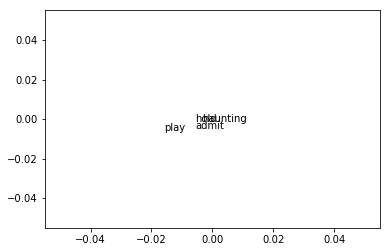

In [10]:
import matplotlib.pyplot as plt
for i in [1, 140, 400, 750]:
    plt.text(U[i,0], U[i,1], dictionary[i])
    plt.axis("tight")
plt.show()

#### Tasks after generating the 2d plot of U [THIS PROCEDURE ALSO WORKS FOR WORD2VEC] :

"I like this movie" -> [I, like, this, movie] -> doc2idx -> [0, 1, 2, 3] -> U[0, 1, 2, 3], -> x1 = sum(vec) / len(sentence)	

1. Input & Target Data:
    a. Prepare X_train using U vector and doc2idx from gensim corpora [use thresholded wordlist for this]
    b. Prepare y_train by marking positive review as 1 and negative review as 0
2. Train a scikit-learn LogisticRegression classifier using Input and Target Data
3. Measure accuracy
4. Plot confusion matrix

In [11]:
# Truncating to just 50 features of U
U_new = U[:,:50] 
U_new.shape

(5464, 50)

In [12]:
# Function to take in a review and convert into a list of vectors for the words in the review
def word_vector(review):
    index_list = dictionary.doc2idx(review)         # The list of the indices of the words from the review in the dictionary
    unnormalized_word_vector = U_new[index_list]    # All the word vectors in U_new corresponding to each word of the review
    word_vector = sum(unnormalized_word_vector)  # Just normalizing the vectors to retain all the features
    #print (word_vector.shape)
    return word_vector

In [13]:
# Constructing the training data 
X_train = []
for review in thresholded_wordlist:
    X_train.append(word_vector(review))
    
X_train = np.asarray(X_train)

y_train = np.zeros(2000)
y_train[:1000] = 1                     # Keeping first half of y as positive 1, and rest as zero; 
                                       # As first half ar positive review, second half are negative review

X_train.shape, y_train.shape

((2000, 50), (2000,))

In [14]:
# Now applying the logistric regression on these training data and then testing accuracy of the training data
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()
LR.fit(X_train, y_train)         # Training with training data
LR.score(X_train, y_train)       # Testing accuracy of this training data

0.86399999999999999

In [17]:
# Applying similar procedure for test data.
# First we need to create the test data wordlist from test database:

df_test = pd.concat((df_pos[DATA_LIMIT:1500], df_neg[DATA_LIMIT:1500]))  # Test database
if 1 != 0:
    wordlist_test = []
    for i in tqdm(range(df_test.shape[0])):
        wordlist_test.append(process_text(df_test['review'].iloc[i]))    # Test dataset created

100%|██████████████████████████████████████████████████████████| 1000/1000 [01:37<00:00, 10.31it/s]


In [18]:
len(wordlist_test)

1000

In [20]:
# Secondly, we create the test data, X_test and y_test
X_test = []
for review in wordlist_test:
    X_test.append(word_vector(review))
X_test = np.asarray(X_test)

y_test = np.zeros(1000)
y_test[:500] = 1

X_test.shape, y_test.shape

((1000, 50), (1000,))

In [24]:
# Lastly finding out the score of the test data with accuracy

LR.score(X_test, y_test)   # In previous assignments, we calculated accuracies by hand by counting and dividing
                           # score() function does this by itself actually

0.73899999999999999

In [25]:
y_pred = LR.predict(X_test)                     # This is required to get the confusion matrix
# Lastly we make a confusioin matrix to see the true positives and false negatives
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[413,  87],
       [174, 326]])